In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('full_data_clustered_ssim_V4.csv')
data = data.replace(np.nan,'None')
data = data.drop(columns=['cluster','cluster_2'])
print(data.shape)

df = data.copy()
df = df[df['Authentication']!='Single system']
df = df[df['Access']!='Unknown']
df = df.reset_index().drop(columns=['level_0'])
print(df.shape)

#after features selection
cols = ['Access','Complexity','Authentication','Conf.','Integ.','Avail']
numerical_cols = ['Score','Number Of Related Vulnerabilities']

from sklearn.preprocessing import MinMaxScaler , StandardScaler
mnScaler = MinMaxScaler()
mn_scaler = mnScaler.fit_transform(df[numerical_cols])

ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1) 
# bad results when we use scaled data in kmeans

ohe = pd.concat([
    pd.get_dummies(df[cols],dtype=float),
    df[numerical_cols]
], axis=1)


for col in cols:
    print(df[col].nunique(),'\t',df[col].unique())
    
ohe.shape

(61698, 22)
(52634, 22)
3 	 ['Remote' 'Local' 'Local Network']
3 	 ['Medium' 'Low' 'High']
2 	 ['Not required' 'Unknown']
3 	 ['None' 'Partial' 'Complete']
3 	 ['Partial' 'None' 'Complete']
3 	 ['None' 'Partial' 'Complete']


(52634, 19)

In [3]:


def clustering_data(x, model):
    
    model.fit_predict(x)
    print(np.unique(model.labels_))    
    cluster_map = pd.DataFrame()
    cluster_map['index_clustermap'] = range(1,len(x)+1)
    cluster_map[f'{model}'] = model.labels_
    cols = ['index','Vulnerability Type(s)','Vulnerability Name','Access','Complexity','Authentication','Conf.','Integ.','Avail'
       ,'Score','Number Of Related Vulnerabilities']
    clustered_data = pd.concat([df[cols] , cluster_map[f'{model}']] , axis=1)
    print(clustered_data[f'{model}'].value_counts())
    
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt    
    n_clusters = 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(x)
    # Plotting the clusters
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        plt.scatter(reduced_data[clustered_data.iloc[:,-1] == i, 0], 
                    reduced_data[clustered_data.iloc[:,-1] == i, 1], label=f'Cluster {i+1}')
    plt.title(f'{clustered_data.columns[-1]} Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    n_clusters = 2
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(x)
    # Plotting the clusters in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_clusters):
        ax.scatter(reduced_data[clustered_data.iloc[:,-1] == i, 0], 
                   reduced_data[clustered_data.iloc[:,-1] == i, 1], 
                   reduced_data[clustered_data.iloc[:,-1] == i, 2], label=f'Cluster {i}')
    ax.set_title(f'{clustered_data.columns[-1]} Clustering (3D)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()
    
    
    import plotly.graph_objects as go
    from sklearn.decomposition import PCA
    n_clusters = 2
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(x)
    # Create a trace for each cluster
    dataa = []
    for i in range(n_clusters):
        trace = go.Scatter3d(
            x=reduced_data[clustered_data.iloc[:,-1] == i, 0],
            y=reduced_data[clustered_data.iloc[:,-1] == i, 1],
            z=reduced_data[clustered_data.iloc[:,-1] == i, 2],
            mode='markers',
            name=f'Cluster {i}',
            marker=dict(size=5)
        )
        dataa.append(trace)
    # Create the layout for the plot
    layout = go.Layout(
        title=f'{clustered_data.columns[-1]} Clustering (3D)',
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3',
        )
    )
    # Create the figure and plot it
    fig = go.Figure(data=dataa, layout=layout)
    fig.show()
    
    
    from sklearn.metrics import silhouette_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.metrics import calinski_harabasz_score

    # Calculate the silhouette score (ranges from -1 to 1, higher is better)
    silhouette_avg = silhouette_score(x, clustered_data.iloc[:,-1])
    print("Silhouette Score:", silhouette_avg)

    # Calculate the Davies-Bouldin index (lower is better)
    davies_bouldin_avg = davies_bouldin_score(x, clustered_data.iloc[:,-1])
    print("Davies-Bouldin Index:", davies_bouldin_avg)

    # Calculate the Calinski ()
    calinski_harabasz_score_avg = calinski_harabasz_score(x, clustered_data.iloc[:,-1])
    print("Calinski Score:", calinski_harabasz_score_avg)

    # Get the sum of squared distances of samples to their closest cluster center (inertia)
#     inertia = model.inertia_
#     print("Inertia:", inertia)
    
    df1 = pd.concat([clustered_data,df['CI SCORE']],axis=1)
    # distribution for each cluster
    cluster_0 = df1[df1[f'{model}']==0]
    cluster_0_scores = cluster_0['CI SCORE']
    cluster_1 = df1[df1[f'{model}']==1]
    cluster_1_scores = cluster_1['CI SCORE']

    plt.figure(figsize=(10,5))
    sn.histplot(cluster_0_scores,label='Cluster 0')
    sn.histplot(cluster_1_scores,label='Cluster 1')

    plt.title('Histogram of CI SCORE by Cluster')
    plt.xlabel('CI SCORE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


    return clustered_data
    
    

# K-Prototypes

In [ ]:
# clustering_data(
#     x = FDataGrid(ohe),
#     model = FuzzyCMeans(n_clusters=2, fuzzifier=2)
# )


In [6]:
from kmodes.kprototypes import KPrototypes

n_clusters = 2
numerical_columns = ['Score','Number Of Related Vulnerabilities']
categorical_columns = ['Access', 'Complexity', 'Authentication', 'Conf.', 'Integ.', 'Avail']

df_array = pd.concat([df[categorical_columns] , df[numerical_columns]] , axis=1).values


kp = KPrototypes(n_clusters=2, init='Cao', verbose=2)

kp_clusters = kp.fit_predict(df_array, categorical=[0,1,2,3,4,5])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7957, ncost: 726969431344.3978
Run: 1, iteration: 2/100, moves: 4448, ncost: 568995618681.0325
Run: 1, iteration: 3/100, moves: 1091, ncost: 555417768723.8721
Run: 1, iteration: 4/100, moves: 0, ncost: 555417768723.8721
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 555417768723.8721
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1394, ncost: 555417768723.8721
Run: 3, iteration: 2/100, moves: 0, ncost: 555417768723.8721
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 5630, ncost: 574062623293.3557
Run: 4, iteration: 2/100, moves: 1301, ncost: 555417768723.8721
Run: 4, iteration: 3/100, moves: 0, n

In [18]:
clustered_data = pd.concat([df[categorical_columns], df[numerical_columns], 
                            pd.DataFrame(kp_clusters,columns=['KPrototypes(n_clusters=2)'])] , axis=1)
clustered_data

,Access,Complexity,Authentication,Conf.,Integ.,Avail,Score,Number Of Related Vulnerabilities,KPrototypes(n_clusters=2)
0,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0
1,Remote,Low,Not required,Partial,Partial,Partial,7.5,3011.0,1
2,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,1
3,Remote,Low,Not required,None,Partial,None,5.0,9380.0,1
4,Local,Low,Not required,Partial,None,None,2.1,394.0,1
...,...,...,...,...,...,...,...,...,...
52629,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0
52630,Remote,Low,Not required,None,None,Partial,5.0,1320.0,1
52631,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,1
52632,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0


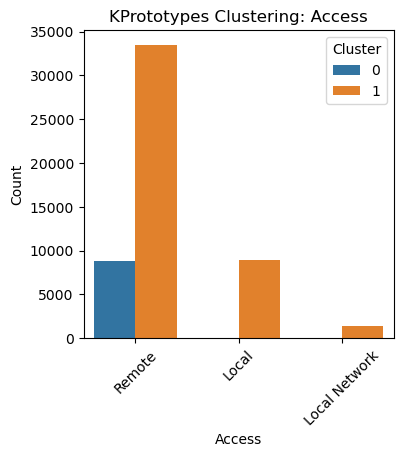

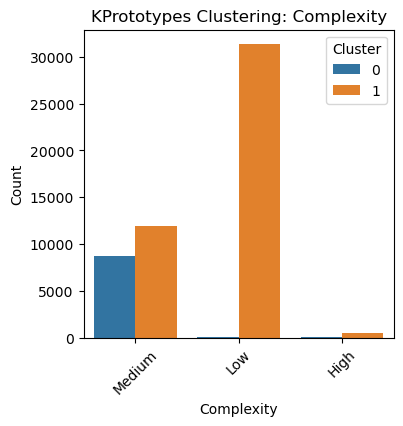

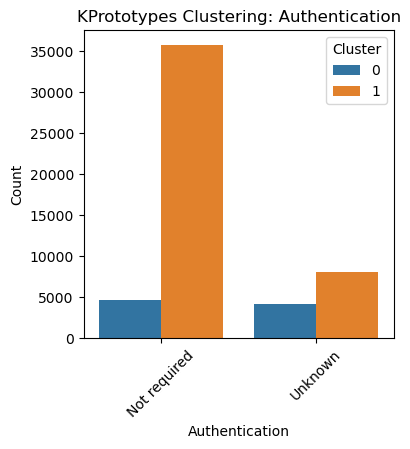

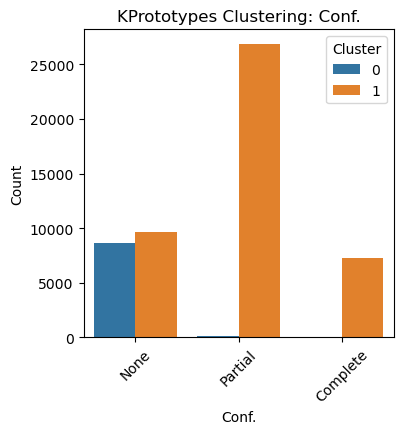

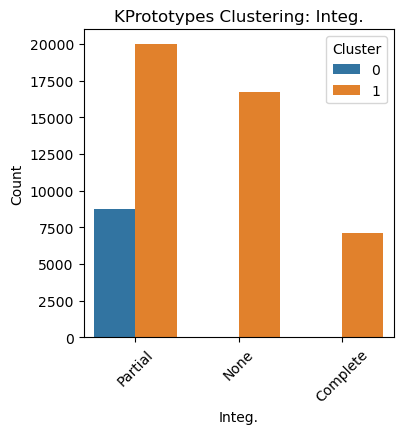

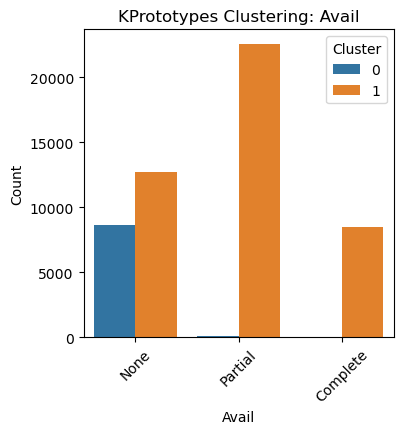

In [33]:
# Visualize categorical features with bar plots
for col in categorical_columns:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=col, hue='KPrototypes(n_clusters=2)', data=clustered_data)
    plt.title(f'KPrototypes Clustering: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.show()


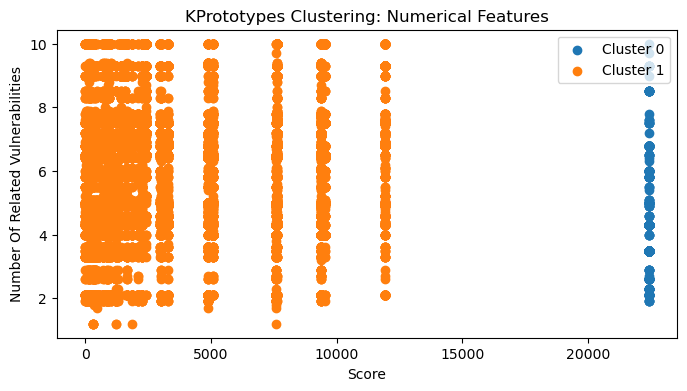

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize numerical features with scatter plots
plt.figure(figsize=(8, 4))
for cluster_id in range(n_clusters):
    cluster_data = clustered_data[clustered_data['KPrototypes(n_clusters=2)'] == cluster_id]
#     plt.scatter(cluster_data['Score'], cluster_data['Number Of Related Vulnerabilities'], label=f'Cluster {cluster_id}')
    plt.scatter(cluster_data['Number Of Related Vulnerabilities'], cluster_data['Score'], label=f'Cluster {cluster_id}')


plt.title('KPrototypes Clustering: Numerical Features')
plt.xlabel('Score')
plt.ylabel('Number Of Related Vulnerabilities')
plt.legend()
plt.show()


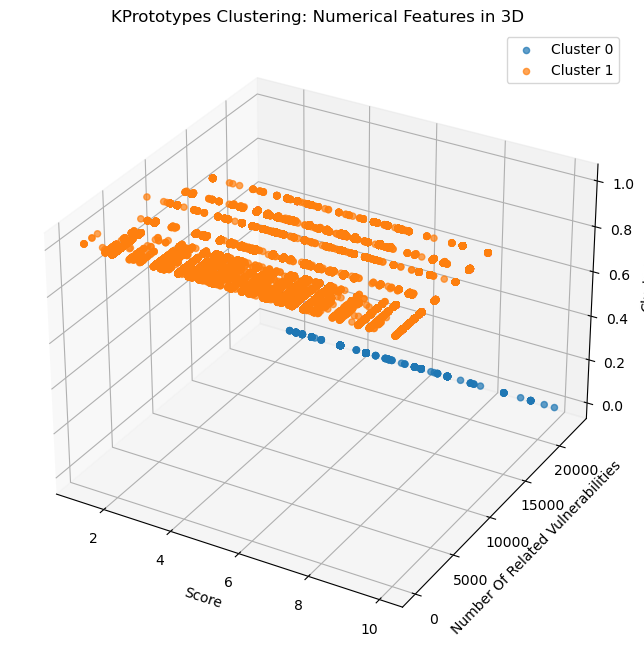

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in range(n_clusters):
    cluster_data = clustered_data[clustered_data['KPrototypes(n_clusters=2)'] == cluster_id]
    ax.scatter(cluster_data['Score'], cluster_data['Number Of Related Vulnerabilities'], [cluster_id] * len(cluster_data),
               label=f'Cluster {cluster_id}', alpha=0.7)

ax.set_title('KPrototypes Clustering: Numerical Features in 3D')
ax.set_xlabel('Score')
ax.set_ylabel('Number Of Related Vulnerabilities')
ax.set_zlabel('Cluster')
ax.legend()
plt.show()



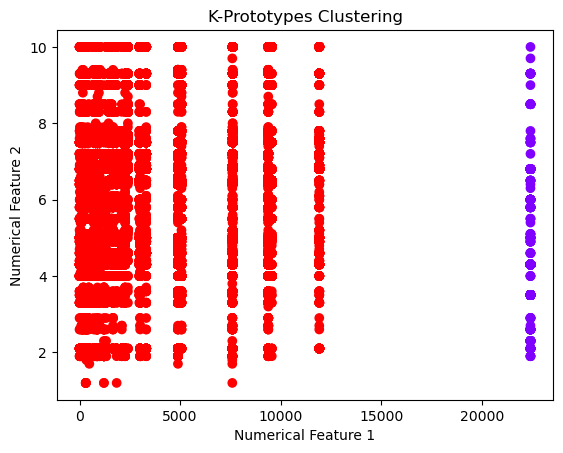

In [35]:
# Scatter plot of clusters
plt.scatter(clustered_data[numerical_columns[1]], clustered_data[numerical_columns[0]], 
            c=clustered_data.iloc[:,-1], cmap='rainbow')
plt.xlabel('Numerical Feature 1')
plt.ylabel('Numerical Feature 2')
plt.title('K-Prototypes Clustering')
plt.show()

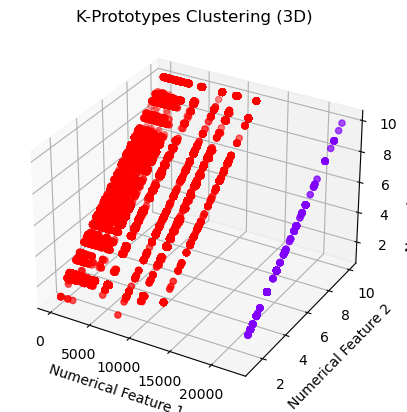

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of clusters in 3D
ax.scatter(clustered_data[numerical_columns[1]], 
           clustered_data[numerical_columns[0]], 
           clustered_data[numerical_columns[0]], c=clustered_data.iloc[:,-1], 
           cmap='rainbow')

ax.set_xlabel('Numerical Feature 1')
ax.set_ylabel('Numerical Feature 2')
ax.set_zlabel('Numerical Feature 3')
ax.set_title('K-Prototypes Clustering (3D)')
plt.show()

# Metrics

In [40]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# Concatenate one-hot encoded categorical and numerical columns into a single array
df_array = pd.concat([pd.DataFrame(encoded_categorical), df[numerical_columns]], axis=1).values
df_array

C:\Users\pc\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 4.3000e+00,
        2.2413e+04],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0000e+00, 7.5000e+00,
        3.0110e+03],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 5.8000e+00,
        7.5400e+02],
       ...,
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 5.8000e+00,
        7.5400e+02],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 4.3000e+00,
        2.2413e+04],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 5.0000e+00,
        4.0300e+02]])

In [42]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Calculate the silhouette score (ranges from -1 to 1, higher is better)
silhouette_avg = silhouette_score(df_array, clustered_data.iloc[:,-1])
print("Silhouette Score:", silhouette_avg)

# Calculate the Davies-Bouldin index (lower is better)
davies_bouldin_avg = davies_bouldin_score(df_array, clustered_data.iloc[:,-1])
print("Davies-Bouldin Index:", davies_bouldin_avg)

# Calculate the Calinski ()
calinski_harabasz_score_avg = calinski_harabasz_score(df_array, clustered_data.iloc[:,-1])
print("Calinski Score:", calinski_harabasz_score_avg)

# Get the sum of squared distances of samples to their closest cluster center (inertia)
# inertia = model.inertia_
# print("Inertia:", inertia)

Silhouette Score: 0.8034477824112006
Davies-Bouldin Index: 0.1718627191336003
Calinski Score: 236171.45735183955
